In [2]:
import skorch
import torch
import torch.nn as nn

from math import ceil
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sine_data import train_dataset, valid_dataset

In [5]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=200)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [6]:
class ClipBPTTWrapper(nn.Module):
    def __init__(self, rnn_layer, hidden_dim, time_steps):
        super().__init__()
        self.rnn_layer = rnn_layer
        self.hidden_dim = hidden_dim
        self.time_steps = time_steps
        
    def init_hidden(self, batch_size, use_cuda):
        v = Variable(torch.zeros(self.hidden_dim, batch_size, self.hidden_dim))
        return v.cuda() if use_cuda else v
    
    def repack(self, h):
        v = Variable(h.data)
        return v.cuda() if h.is_cuda else v
    
    def rnn(self, x, h):
        return self.rnn_layer(x, h)
        
    def forward(self, x):
        num_steps = ceil(x.size(1) / self.time_steps)
        chunks = torch.chunk(x, num_steps, dim=1)
        h = self.init_hidden(x.size(0), x.is_cuda)
        ys = []
        
        for chunk in chunks:
            h = self.repack(h) # limit backprop to one chunk
            y, h = self.rnn(chunk, h)
            ys.append(y[:,-1])
        return torch.stack(ys, dim=1), h

In [7]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [8]:
class RepeatingRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        repeats = ceil(target_length / x.size(1))
                
        parts = []
        for ti in range(x.size(1)):
            xr = x[:, ti:(ti+1)].repeat(1, repeats, 1)
            parts.append(xr)
        
        x_rep = torch.cat(parts, dim=1)
        y, h = self.rnn_layer(x_rep)
        return y[:, :target_length], h

In [48]:
class ContextDecoderRNN(nn.Module):
    def __init__(self, rnn_layer):
        super().__init__()
        self.rnn_layer = rnn_layer
        
    def forward(self, x, target_length):
        # at time-step target_length % x.size(1) switch context to next value from x
        cidx = 0
        h = x[:, cidx:(cidx+1)].transpose(0, 1) # make context (t, b, u)
        y_tm1 = Variable(torch.zeros(x.size(0), 1, x.size(-1)))
        y_tm1 = y_tm1.cuda() if x.is_cuda else y_tm1
        ys = []
        # every nth step an update happens
        update_step = target_length // x.size(1)
        for ti in range(target_length):
            y, h_new = self.rnn_layer(y_tm1, h)
            ys.append(y)
            y_tm1 = y
            if ti > 0 and ti % update_step == 0:
                h = x[:, cidx:(cidx+1)].transpose(0, 1)
                cidx += 1
            else:
                h = y_tm1.transpose(0, 1)
        return torch.stack(ys, dim=1), h

In [72]:
class ReconModel(nn.Module):
    def __init__(
        self, 
        num_hidden=16, 
        num_timesteps_per_chunk_0=20, 
        num_timesteps_per_chunk_1=2, 
        baseline=False,
    ):
        super().__init__()
        
        # t -> ceil(t/20) timesteps
        layer_0 = nn.GRU(1, num_hidden, batch_first=True)
        self.rnn_enc_0 = ClipBPTTWrapper(layer_0, num_hidden, num_timesteps_per_chunk_0)
        
        # ceil(t/20) -> ceil(ceil(t/20)/2) timesteps
        layer_1 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_enc_1 = ClipBPTTWrapper(layer_1, num_hidden, num_timesteps_per_chunk_1)
        
        # ceil(ceil(t/20)/2) chunks total as hidden repr. (3 for t=100)
        # so we now want 3 -> 100 again (recon task)
        # we do this by generating 100//3 for each chunk
        layer_2 = nn.GRU(num_hidden, num_hidden, batch_first=True)
        self.rnn_dec_1 = RepeatingRNN(layer_2)
        #self.rnn_dec_1 = ContextDecoderRNN(layer_2)

        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        l0, h0 = self.rnn_enc_0(x)
        l1, h1 = self.rnn_enc_1(l0)
        l2, h2 = self.rnn_dec_1(l1, x.size(1))
        clf = self.clf(l2)
        return time_unflatten(clf, x.size())

In [73]:
class Trainer(skorch.NeuralNet):
    def __init__(self, 
                 criterion=nn.MSELoss,
                 *args, 
                 **kwargs):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, train=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, train=train)

## with clip

In [74]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef_with = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.005,
             max_epochs=120,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__num_timesteps_per_chunk_0=11,
             module__num_timesteps_per_chunk_1=2,
            )

In [75]:
%pdb on
ef_with.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.9401        1.7514  0.6790
      2        1.7812        1.6129  0.7652
      3        1.6372        1.4759  0.5975
      4        1.4944        1.3337  0.6001
      5        1.3456        1.1845  0.6872
      6        1.1889        1.0325  0.5601
      7        1.0284        0.8882  0.6439
      8        0.8743        0.7679  0.6431
      9        0.7430        0.6906  0.6761
     10        0.6538        0.6699  0.6698
     11        0.6212        0.6999  0.7294
     12        0.6406        0.7509  0.5442
     13        0.6840        0.7911  0.7049
     14        0.7205        0.8062  0.6256
     15        0.7350        0.7961  0.6751
     16        0.7268        0.7671  0.5477
     17        0.7017        0.7278  0.6284
     18        0.6676        0.6866  0.5877
     19        0.6326        0.6506  0.6536
     20        0.6033        0.6248

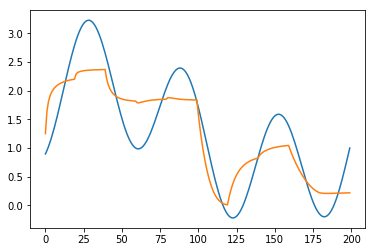

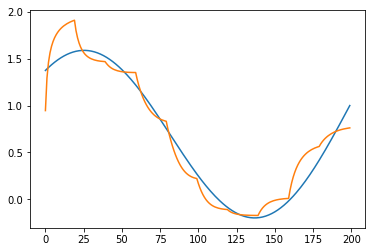

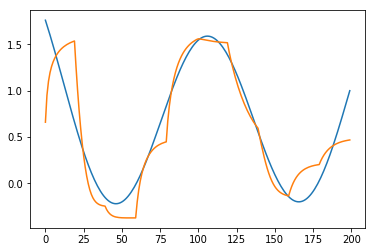

In [76]:
data = X_valid
pred = ef_with.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])